POPPY (https://github.com/mperrin/poppy, http://adsabs.harvard.edu/abs/2016ascl.soft02018P) can be used to model diffraction across the Fresnel and Fraunhofer regimes using the angular spectrum approach.

This example propagates light through an early design of the afocal telescope for the PICTURE-C high contrast imaging balloon (which is primarily simulated in PROPER). 

The design includes several image pupil and image planes for a deformable mirror and an image plane coronagraph (the operation of which is not included in this simulation).

For more detailed explanations and details on this layout, see Douglas et al. 2015 and Mendillo et al. 2015.

* Douglas, Ewan S., Kuravi Hewasawam, Christopher B. Mendillo, Kerri L. Cahoy, Timothy A. Cook, Susanna C. Finn, Glenn A. Howe, et al. 2015. “End-to-End Simulation of High-Contrast Imaging Systems: Methods and Results for the PICTURE Mission Family.” In Proc. SPIE, 9605:96051A–96051A–13. [doi:10.1117/12.2187262](https://doi.org/10.1117/12.2187262).

* Mendillo, Christopher B., Joshua Brown, Jason Martel, Glenn A. Howe, Kuravi Hewasawam, Susanna C. Finn, Timothy A. Cook, et al. 2015. “The Low-Order Wavefront Sensor for the PICTURE-C Mission.” In Proc. SPIE, 9605:960519-960519–12. [doi:10.1117/12.2188238](https://doi.org/10.1117/12.2188238).


In [1]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm 
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)


POPPY Version: 0.5.0


The system is stored as a csv file describing each optics prescription and the distance between them. 
For this demonstration neglects the surface error PSD coefficients and ideally propagates between each optic using the separation and focal length.

In [27]:

#import data in inches:
inches=u.imperial.inch
sys=np.genfromtxt('data/rx_afocal_old.csv',delimiter=',', 
                  dtype="U10,=U10,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,S5,S5,",
                  skip_header=16,names=True)
print("the names of the headers are:")
print(sys.dtype.names)


the names of the headers are:
('Name', 'Type', 'Focal_Length_in', 'Distance_in', 'Radius_in', 'Angle_deg', 'Surf_PSD_A', 'Surf_PSD_B', 'Surf_PSD_C', 'Surf_PSD_D', 'Ref_PSD_A', 'Ref_PSD_B', 'Ref_PSD_C', 'Ref_PSD_D', 'Coating', 'Material')


## Populate the optical system

In [3]:
npix=256 #this is the number of pixels across the pupil
wavelength=675e-9 #meters
primary_r=sys['Radius_in'][0]*inches
primary_fl=sys['Focal_Length_in'][0]*inches

pic_c_sys = poppy.FresnelOpticalSystem(pupil_diameter=2*primary_r, 
                                       npix=npix,
                                       beam_ratio=.34)#beam_ratio is the oversampling convention used in PROPER

entrance=poppy.CircularAperture(radius=primary_r.to(u.m).value)
pic_c_sys.add_optic(entrance)
for n_optic,optic in enumerate(sys):

    fl=optic['Focal_Length_in'] *inches
    
    #roll the distances by one, and don't propagate after the last optic
    # Since the POPPY system convention is the location of the optic 
    #and the PICSIM convention is the distance after the optic,
    dz = sys[n_optic]['Distance_in'] * inches

    if (n_optic == 0): 
        dz_sys = 0*u.m
    else:
        dz_sys = sys[n_optic-1]['Distance_in'] * inches

    if fl !=0:
        gl=poppy.fresnel.QuadraticLens(fl,name=optic['Name'])
        pic_c_sys.add_optic(gl,distance=dz_sys)
        pic_c_sys.add_optic(poppy.CircularAperture(radius=(optic['Radius_in']*inches).to(u.m).value,
                           name=optic['Name']+" aperture"))
    elif n_optic == sys.size-1:
        #if focal lengths worked, this could be an image
        pic_c_sys.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                                     name=optic['Name']), distance=dz_sys)
        #image plane doesn't get a circular aperture
    else:
        pic_c_sys.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                                     name=optic['Name']), distance=dz_sys)
        pic_c_sys.add_optic(poppy.CircularAperture(radius=(optic['Radius_in']*inches).to(u.m).value,
                                                   name=optic['Name']+" aperture"))
    #mask the beam by the size of the optic
    

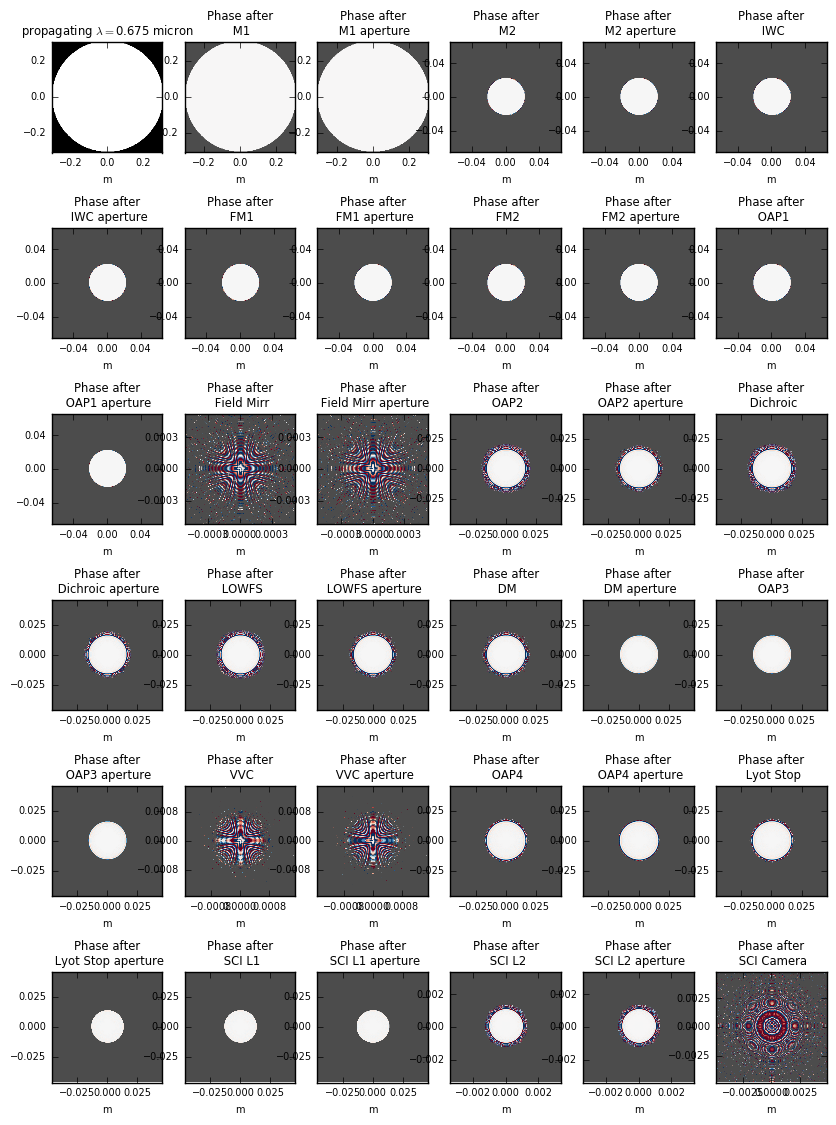

In [4]:
matplotlib.rcParams["font.size"]=7
plt.figure(figsize=[10,14])
import matplotlib.rcsetup
psf, intermed_wfs = pic_c_sys.calcPSF(wavelength=wavelength,
                                      display_intermediates=True,
                                      return_intermediates=True)


## Examine the wavefront intensity at each surface

The plots above show the phase at each plane, but since we saved the intermediate phases we can go back and plot the intensity or other parameters at each plane.
This time manually plotting the intensity array instead of calling the display() function illustrates interacting with the underlying data.

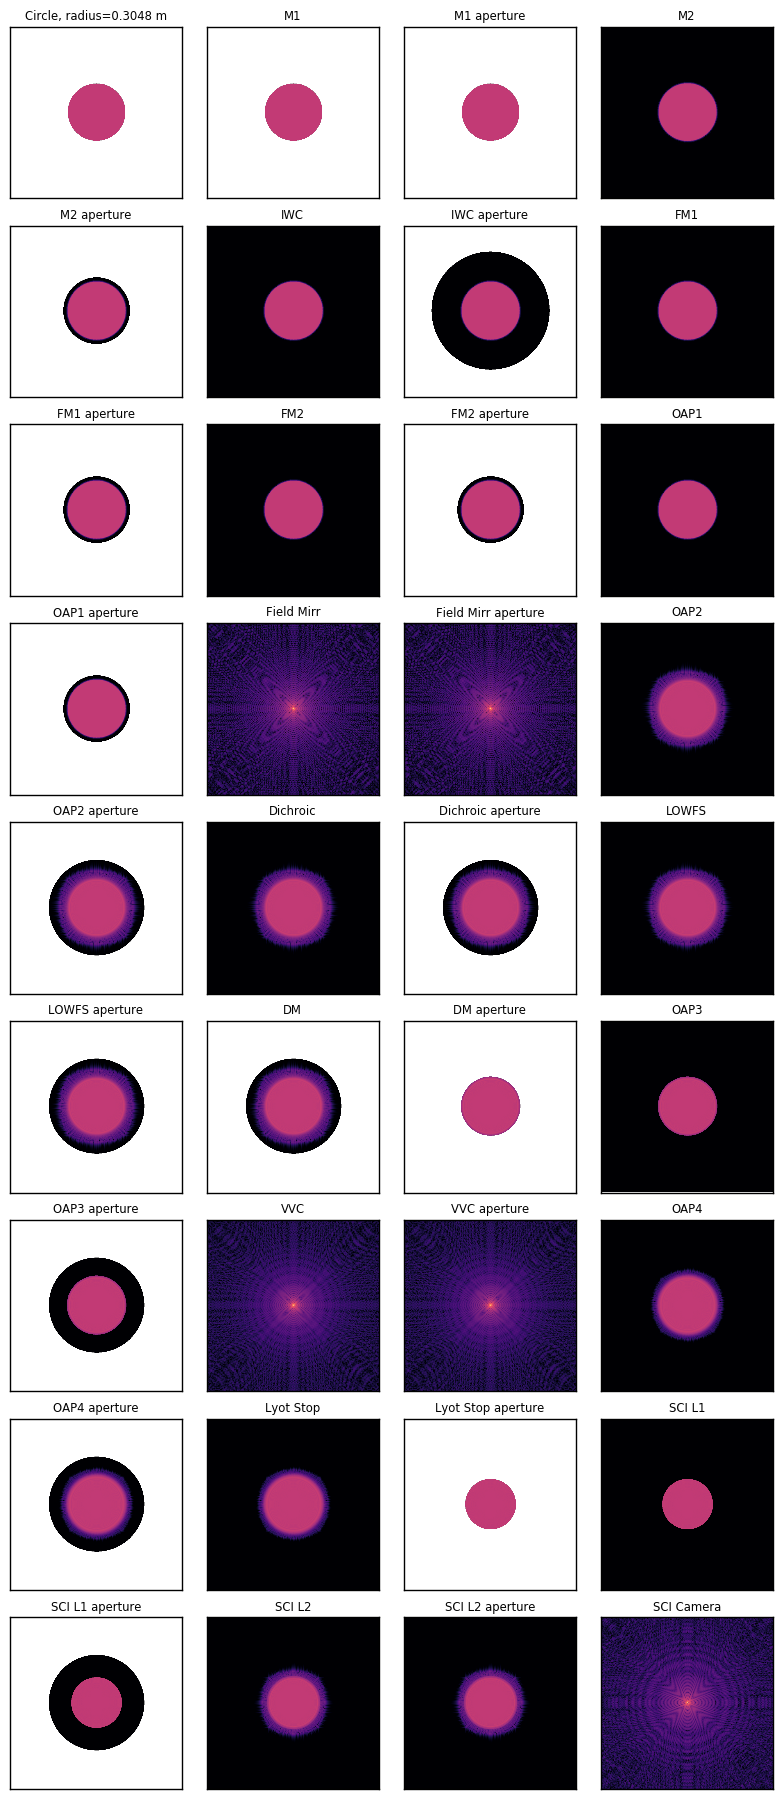

In [5]:
plt.figure(figsize=[8,18])
matplotlib.rcParams["font.size"]=7


for i in range(len(intermed_wfs)):
    ax= plt.subplot(9,4 ,i+1)
    #m
    im=ax.imshow(intermed_wfs[i].intensity,
                 cmap=plt.cm.magma,
                 norm=LogNorm(vmin=1e-10, vmax=1))#(1e-10,1))
    #plt.title(i)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    plt.title(pic_c_sys.planes[i].name)


plt.tight_layout()



## Examine the PSF 

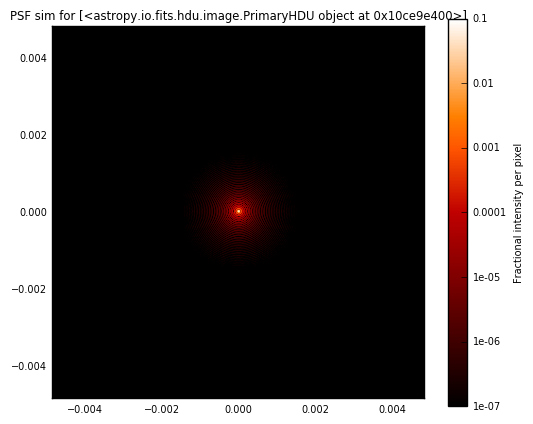

In [6]:
plt.figure(figsize=[6,5])

poppy.display_PSF(psf)

## Examine the PSF Core

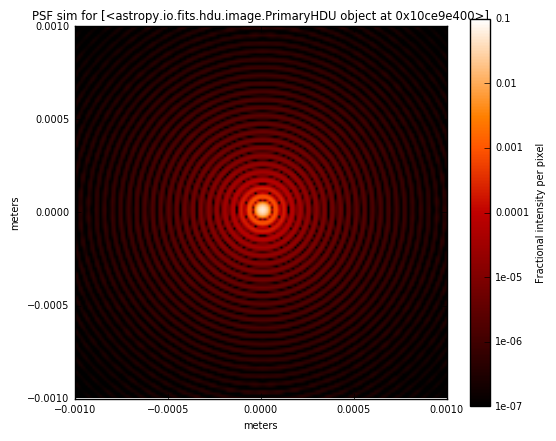

In [7]:
plt.figure(figsize=[6,5])

poppy.display_PSF(psf,imagecrop=.002)
plt.xlabel("meters")
plt.ylabel("meters")

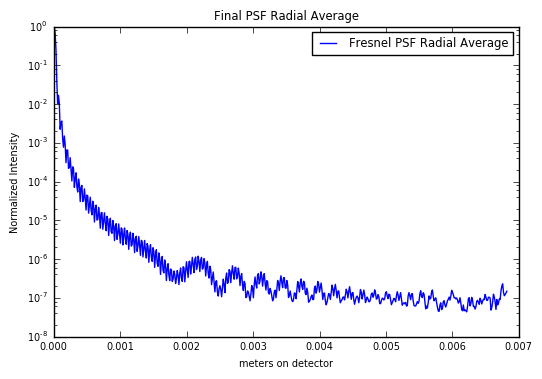

In [8]:

profile=poppy.utils.radial_profile(psf)

#plot radial averages:
plt.figure()
plt.plot(profile[0],profile[1]/profile[1].max(),"-",label="Fresnel PSF Radial Average")


plt.yscale("log")
plt.ylabel("Normalized Intensity")
plt.xlabel("meters on detector")
plt.title("Final PSF Radial Average")
plt.legend()



## Benchmark the the optical system

In [33]:
%%bash
#get CPU model and total RAM:
#print system info, the reference system is a 13" 2012 Macbook Pro with:
#Intel(R) Core(TM) i5-3210M CPU @ 2.50GHz
#hw.memsize: 8589934592

sysctl -n machdep.cpu.brand_string  #for Macs
sysctl hw.memsize  #for Macs

cat /proc/cpuinfo | grep model #for Linux
cat /proc/meminfo  | grep MemTotal #for Linux



Intel(R) Core(TM) i5-3210M CPU @ 2.50GHz
hw.memsize: 8589934592


cat: /proc/cpuinfo: No such file or directory
cat: /proc/meminfo: No such file or directory


In [9]:

%timeit psf = pic_c_sys.calcPSF(wavelength=675e-9,display_intermediates=False,return_intermediates=False)



1 loop, best of 3: 6.22 s per loop


PyFFTW can speed up FFTs, https://pypi.python.org/pypi/pyFFTW,
generally, np.fft is faster for small arrays, since it has less overhead, and pyfftw is faster for big arrays.

In [11]:
poppy.conf.use_fftw=True
%timeit pic_c_sys.calcPSF(wavelength=675e-9,display_intermediates=False,return_intermediates=False)
#1 loops, best of 3: 1min 54s per loop

1 loop, best of 3: 6.24 s per loop


In [12]:
poppy.conf.use_fftw=False
%timeit pic_c_sys.calcPSF(wavelength=675e-9,display_intermediates=False,return_intermediates=False)



1 loop, best of 3: 8 s per loop


### Compare FFT speeds for lot of pixels (this could take a few minutes)

In [28]:
pic_c_sys.npix=512
poppy.conf.use_fftw=True
%timeit pic_c_sys.calcPSF(wavelength=675e-9,display_intermediates=False,return_intermediates=False)

1 loop, best of 3: 19.3 s per loop


In [29]:
poppy.conf.use_fftw=False
%timeit pic_c_sys.calcPSF(wavelength=675e-9,display_intermediates=False,return_intermediates=False)

1 loop, best of 3: 25.5 s per loop


### Compare FFT speeds for a small array

In [23]:
pic_c_sys.npix=64
poppy.conf.use_fftw=True
%timeit pic_c_sys.calcPSF(wavelength=675e-9,display_intermediates=False,return_intermediates=False)

1 loop, best of 3: 2.27 s per loop


In [24]:
poppy.conf.use_fftw=False
%timeit pic_c_sys.calcPSF(wavelength=675e-9,display_intermediates=False,return_intermediates=False)

1 loop, best of 3: 2.21 s per loop
